In [16]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pybgs as bgs
import time

## Param

In [17]:
kernel = np.ones((1, 1), np.uint8)
kernel2 = np.ones((2, 2), np.uint8)
kernel3 = np.ones((3, 3), np.uint8)
kernel4 = np.ones((4, 4), np.uint8)
kernel5 = np.ones((5, 5), np.uint8)
kernel6 = np.ones((6, 6), np.uint8)
kernel7 = np.ones((7, 7), np.uint8)
kernel8 = np.ones((8, 8), np.uint8)
kernel9 = np.ones((9, 9), np.uint8)

In [18]:
path = './test_data'
files = sorted(os.listdir(path), key=len)
files.sort(key = lambda x: int(x[:-4]))
files_num = len(files)

In [19]:
old_bg_img = cv2.imread('../../data/background/bg_history.png')
mask_flow = cv2.imread('../../data/masks/mask_flow.png', flags = cv2.IMREAD_GRAYSCALE)

In [20]:
# Center
mask_center = cv2.imread('../../data/masks/mask_center.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_center = cv2.threshold(mask_center, 10, 255, cv2.THRESH_BINARY)

# left down, from center to edge
mask_ldf = cv2.imread('../../data/masks/mask_ldf.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_ldf = cv2.threshold(mask_ldf, 10, 255, cv2.THRESH_BINARY)

# left down, towards center
mask_ldt = cv2.imread('../../data/masks/mask_ldt.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_ldt = cv2.threshold(mask_ldt, 10, 255, cv2.THRESH_BINARY)

# left down, towards center, left trun
mask_ldt_l = cv2.imread('../../data/masks/mask_ldt_left.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_ldt_l = cv2.threshold(mask_ldt_l, 10, 255, cv2.THRESH_BINARY)

# left upper, from center to edge
mask_luf = cv2.imread('../../data/masks/mask_luf.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_luf = cv2.threshold(mask_luf, 10, 255, cv2.THRESH_BINARY)

# left upper, towards center
mask_lut = cv2.imread('../../data/masks/mask_lut.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_lut = cv2.threshold(mask_lut, 10, 255, cv2.THRESH_BINARY)

# left upper, towards center, left trun
mask_lut_l = cv2.imread('../../data/masks/mask_lut_left.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_lut_l = cv2.threshold(mask_lut_l, 10, 255, cv2.THRESH_BINARY)

# right down, from center to edge
mask_rdf = cv2.imread('../../data/masks/mask_rdf.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_rdf = cv2.threshold(mask_rdf, 10, 255, cv2.THRESH_BINARY)

# right down, towards center
mask_rdt = cv2.imread('../../data/masks/mask_rdt.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_rdt = cv2.threshold(mask_rdt, 10, 255, cv2.THRESH_BINARY)

# right down, towards center, left trun
mask_rdt_l = cv2.imread('../../data/masks/mask_rdt_left.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_rdt_l = cv2.threshold(mask_rdt_l, 10, 255, cv2.THRESH_BINARY)

# right upper, from center to edge
mask_ruf = cv2.imread('../../data/masks/mask_ruf.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_ruf = cv2.threshold(mask_ruf, 10, 255, cv2.THRESH_BINARY)
# right upper, towards center
mask_rut = cv2.imread('../../data/masks/mask_rut.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_rut = cv2.threshold(mask_rut, 10, 255, cv2.THRESH_BINARY)

# right upper, towards center, left trun
mask_rut_l = cv2.imread('../../data/masks/mask_rut_left.png', flags = cv2.IMREAD_GRAYSCALE)
_, mask_rut_l = cv2.threshold(mask_rut_l, 10, 255, cv2.THRESH_BINARY)

In [21]:
mask_tuple = (mask_center, mask_ldf, mask_ldt, mask_ldt_l,
              mask_luf, mask_lut, mask_lut_l,
              mask_rdf, mask_rdt, mask_rdt_l,
              mask_ruf, mask_rut, mask_rut_l)

In [22]:
crop_position = [[370,100],[480,0],[480,0],[480,0],
                [0,0],[100,0],[100,0],
                [480,300],[480,400],[480,400],
                [50,380],[0,300],[0,300]]

## BgOpticalFlowTrigger

In [23]:
class BgOpticalFlowTrigger():
    def __init__(self, img, mask_flow, zone_mask_tuple):
        self.mask_flow = mask_flow
        self.zone_mask_tuple = zone_mask_tuple
        img_prev_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        self.img_prev_gray = cv2.bitwise_and(img_prev_gray, img_prev_gray, mask = mask_flow)
        self.flow_region_mean_prev = 0
        
    def update(self, img):
        # Mask incoming frame
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.bitwise_and(img_gray, img_gray, mask = self.mask_flow)
        
        # Calculate optical flow
        flow = cv2.calcOpticalFlowFarneback(self.img_prev_gray, 
                                            img_gray, 
                                            None, 0.5, 3, 15, 3, 5, 1.2, 0)
        
        # Update previous frame
        self.img_prev_gray = img_gray.copy()
        
        # Process magnitude of Optical flow
        mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        mag[np.isinf(mag)] = 0 # sometimes flow elements of 0 is reagarded as a number close to 0 but not equal to 0 by Python, then the cartToPolar function will get an inf value.
        mag[np.isnan(mag)] = 0
        self.mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8U) #  mag shape: (960, 1280)
        _, flow_contour = cv2.threshold(self.mag, 40, 255, cv2.THRESH_BINARY)
        
        ################### Morphlogical Transformation #######################
        contours, _ = cv2.findContours(flow_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            if cv2.contourArea(contour) < 100:
                cv2.fillConvexPoly(flow_contour, contour, (0, 0, 0))
                
        flow_contour = cv2.morphologyEx(flow_contour, cv2.MORPH_OPEN, kernel, iterations=1)
        flow_contour = cv2.dilate(flow_contour, kernel3, iterations=1)
        
        contours, _ = cv2.findContours(flow_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            cv2.fillConvexPoly(flow_contour, contour, (255,255,255))
            
        contours, _ = cv2.findContours(flow_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            if cv2.contourArea(contour) < 100:
                cv2.fillConvexPoly(flow_contour, contour, (0,0,0))
                
        contours, _ = cv2.findContours(flow_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            if cv2.contourArea(contour) < 100:
                cv2.fillConvexPoly(flow_contour, contour, (0,0,0))
        ################### Morphlogical Transformation #######################
        
        self.contours, _ = cv2.findContours(flow_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        self.flow_contour = flow_contour.copy()
        
    def is_zone_triggered(self, zone_id):
        cur_mask = self.zone_mask_tuple[zone_id].copy()
        
        flow_region = cv2.bitwise_and(self.flow_contour, self.flow_contour, cur_mask)
        flow_region_contours, _ = cv2.findContours(flow_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        total_area = 0
        for contour in flow_region_contours:
            total_area += cv2.contourArea(contour)
            
        flow_region_mean = 0
        flow_region_mean = cv2.mean(cv2.bitwise_and(self.mag, self.mag, mask = flow_region),
                                         mask = flow_region)[0]
        
        if total_area > 3000 and flow_region_mean > 50 and flow_region_mean > self.flow_region_mean_prev:
            self.flow_region_mean_prev = flow_region_mean
            return True
        else:
            self.flow_region_mean_prev = flow_region_mean
            return False

## ZoneInitializer

In [24]:
class ZoneInitializer():
    def __init__(self, bg_img, zone_mask_tuple, zone_id):
        # Zone mask
        cur_zone_mask = zone_mask_tuple[zone_id].copy()
        _, self.zone_mask = cv2.threshold(cur_zone_mask, 10, 255, cv2.THRESH_BINARY)
        
        # Init SIFT, GMM
        self.sift = cv2.SIFT_create()
        self.bgs_model = bgs.MixtureOfGaussianV2()

        # Init Matcher
        FLANN_INDEX_KDTREE=0
        indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        searchParams = dict(checks = 50)
        self.flann = cv2.FlannBasedMatcher(indexParams, searchParams)

        # Load old bg for the matcher
        old_bg = cv2.bitwise_and(bg_img, bg_img, mask = self.zone_mask) # template background
        _, self.des_prev_bg = self.sift.detectAndCompute(old_bg, None) # sift descriptor of the template background
        
        # Parameters
        self.score = 0
        self.best_score = 0
        self.update_flag = False
        self.init_flag = True

    def get_cur_bgs(self):
        return self.bgs_model.getBackgroundModel()
    
    def get_bg(self):
        if self.update_flag == False:
            return self.get_cur_bgs()
        else:
            return self.bg_output

    def bgs_model_update(self, frame):
        update_region = cv2.bitwise_and(frame, frame, mask = self.zone_mask)
        self.bgs_model.apply(update_region)
        self.init_flag = False

    def compare_sift(self):
        # Calculate sift descriptor from current bgs model
        _, des_cur_bg = self.sift.detectAndCompute(self.get_cur_bgs(), None)
        
        # Calculate match score
        matches = self.flann.knnMatch(self.des_prev_bg, des_cur_bg, k = 2)
        matchNum = [m for (m, n) in matches if m.distance < 0.8 * n.distance]
        self.score = len(matchNum) / len(matches)
        
        # Update bg_output
        if self.score > self.best_score:
            self.best_score = self.score
            self.bg_output = self.get_cur_bgs() # generated background
            self.update_flag = True
    
    def bg_update(self, frame, of_trigger = True, sift_flg = True):
        if self.init_flag or of_trigger:
            self.bgs_model_update(frame) # update bgs model when triggered
            
        if sift_flg:
            self.compare_sift() # only update BG when have higher score
        else:
            self.bg_output = self.get_cur_bgs() # always update BG
            self.update_flag = True

## Test (One Zone)

################ Frame: 1 ################ 2.jpg
0.45588235294117646
################ Frame: 2 ################ 3.jpg
0.45588235294117646
################ Frame: 3 ################ 4.jpg
0.45588235294117646
################ Frame: 4 ################ 5.jpg
0.45588235294117646
################ Frame: 5 ################ 6.jpg
0.46568627450980393
################ Frame: 6 ################ 7.jpg
0.46568627450980393
################ Frame: 7 ################ 8.jpg
0.46568627450980393
################ Frame: 8 ################ 9.jpg
0.46568627450980393
################ Frame: 9 ################ 10.jpg
0.46568627450980393
################ Frame: 10 ################ 11.jpg
0.46568627450980393
################ Frame: 11 ################ 12.jpg
0.46568627450980393
################ Frame: 12 ################ 13.jpg
0.46568627450980393
################ Frame: 13 ################ 14.jpg
0.46568627450980393
################ Frame: 14 ################ 15.jpg
0.46568627450980393
################ Frame:

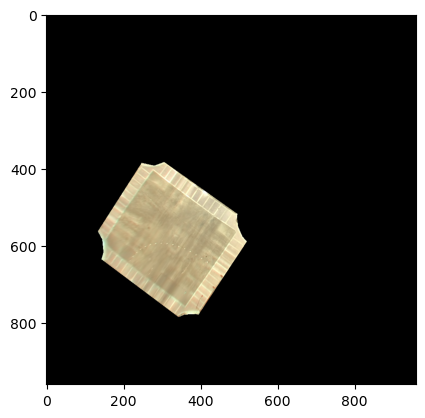

OF Trigger: True
Time/frame 0.3590624737739563


In [29]:
# OF & SIFT
idx_frame = 0
img = cv2.imread(os.path.join(path,files[idx_frame])) # read the first image

start_time = time.time()

of_trigger = BgOpticalFlowTrigger(img, mask_flow, mask_tuple)
zone_0_init = ZoneInitializer(old_bg_img, mask_tuple, 0) # renew module of bgslibrary and sift

while 1:
    idx_frame += 1
    if idx_frame >= 100: break

    img = cv2.imread(os.path.join(path,files[idx_frame]))

    of_trigger.update(img)
    
    zone_0_init.bg_update(img, of_trigger.is_zone_triggered(0))

    print('################ Frame:', idx_frame, '################',files[idx_frame])
    print(zone_0_init.best_score)
    
plt.imshow(zone_0_init.get_bg())
plt.show()

print('OF Trigger:', zone_0_init.update_flag)
print('Time/frame', (time.time() - start_time)/100)

################ Frame: 1 ################ 2.jpg
################ Frame: 2 ################ 3.jpg
################ Frame: 3 ################ 4.jpg
################ Frame: 4 ################ 5.jpg
################ Frame: 5 ################ 6.jpg
################ Frame: 6 ################ 7.jpg
################ Frame: 7 ################ 8.jpg
################ Frame: 8 ################ 9.jpg
################ Frame: 9 ################ 10.jpg
################ Frame: 10 ################ 11.jpg
################ Frame: 11 ################ 12.jpg
################ Frame: 12 ################ 13.jpg
################ Frame: 13 ################ 14.jpg
################ Frame: 14 ################ 15.jpg
################ Frame: 15 ################ 16.jpg
################ Frame: 16 ################ 17.jpg
################ Frame: 17 ################ 18.jpg
################ Frame: 18 ################ 19.jpg
################ Frame: 19 ################ 20.jpg
################ Frame: 20 ################ 21.j

<ipython-input-88-6c80eb0ae870>:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.bg_output == np.zeros((960,960)):


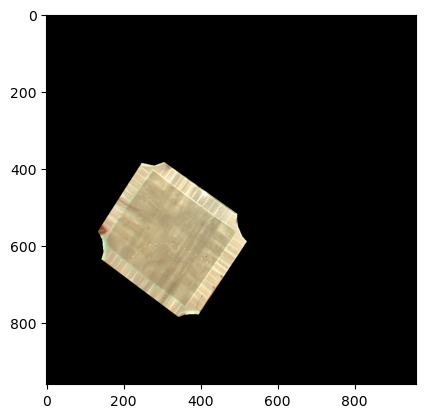

Time/frame 0.2156295347213745


In [90]:
# OF only
idx_frame = 0
img = cv2.imread(os.path.join(path,files[idx_frame])) # read the first image

start_time = time.time()

of_trigger = BgOpticalFlowTrigger(img, mask_flow, mask_tuple)
zone_0_init = ZoneInitializer(old_bg_img, mask_tuple, 0) # renew module of bgslibrary and sift

while 1:
    idx_frame += 1
    if idx_frame >= 100: break

    img = cv2.imread(os.path.join(path,files[idx_frame]))

    of_trigger.update(img)
    zone_0_init.bg_update(img, of_trigger.is_zone_triggered(0), sift_flg = False)

    print('################ Frame:', idx_frame, '################',files[idx_frame])
    
plt.imshow(zone_0_init.get_bg())
plt.show()

print('Time/frame', (time.time() - start_time)/100)

################ Frame: 1 ################ 2.jpg
################ Frame: 2 ################ 3.jpg
################ Frame: 3 ################ 4.jpg
################ Frame: 4 ################ 5.jpg
################ Frame: 5 ################ 6.jpg
################ Frame: 6 ################ 7.jpg
################ Frame: 7 ################ 8.jpg
################ Frame: 8 ################ 9.jpg
################ Frame: 9 ################ 10.jpg
################ Frame: 10 ################ 11.jpg
################ Frame: 11 ################ 12.jpg
################ Frame: 12 ################ 13.jpg
################ Frame: 13 ################ 14.jpg
################ Frame: 14 ################ 15.jpg
################ Frame: 15 ################ 16.jpg
################ Frame: 16 ################ 17.jpg
################ Frame: 17 ################ 18.jpg
################ Frame: 18 ################ 19.jpg
################ Frame: 19 ################ 20.jpg
################ Frame: 20 ################ 21.j

<ipython-input-88-6c80eb0ae870>:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.bg_output == np.zeros((960,960)):


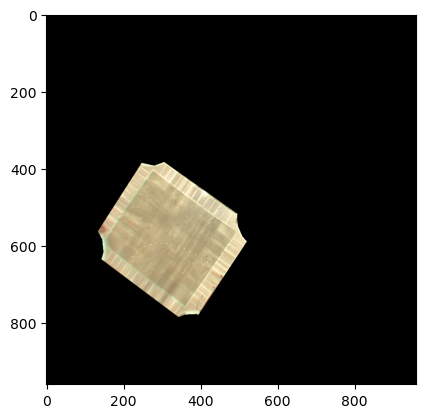

Time/frame 0.16773110628128052


In [89]:
# SIFT only
idx_frame = 0
img = cv2.imread(os.path.join(path,files[idx_frame])) # read the first image

start_time = time.time()

# of_trigger = BgOpticalFlowTrigger(img, mask_flow, mask_tuple)
zone_0_init = ZoneInitializer(old_bg_img, mask_tuple, 0) # renew module of bgslibrary and sift

while 1:
    idx_frame += 1
    if idx_frame >= 100: break

    img = cv2.imread(os.path.join(path,files[idx_frame]))

    # of_trigger.update(img)
    zone_0_init.bg_update(img)

    print('################ Frame:', idx_frame, '################',files[idx_frame])
    
plt.imshow(zone_0_init.get_bg())
plt.show()

print('Time/frame', (time.time() - start_time)/100)

################ Frame: 1 ################ 2.jpg
################ Frame: 2 ################ 3.jpg
################ Frame: 3 ################ 4.jpg
################ Frame: 4 ################ 5.jpg
################ Frame: 5 ################ 6.jpg
################ Frame: 6 ################ 7.jpg
################ Frame: 7 ################ 8.jpg
################ Frame: 8 ################ 9.jpg
################ Frame: 9 ################ 10.jpg
################ Frame: 10 ################ 11.jpg
################ Frame: 11 ################ 12.jpg
################ Frame: 12 ################ 13.jpg
################ Frame: 13 ################ 14.jpg
################ Frame: 14 ################ 15.jpg
################ Frame: 15 ################ 16.jpg
################ Frame: 16 ################ 17.jpg
################ Frame: 17 ################ 18.jpg
################ Frame: 18 ################ 19.jpg
################ Frame: 19 ################ 20.jpg
################ Frame: 20 ################ 21.j

<ipython-input-85-cda7407391fd>:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.bg_output == np.zeros((960,960)):


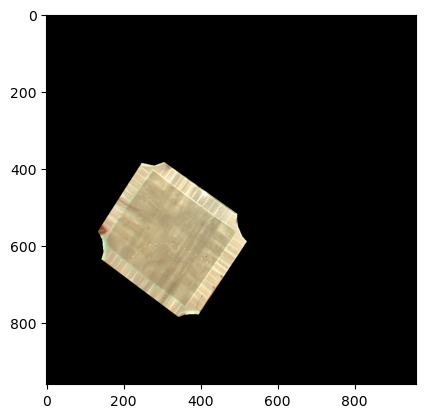

Time/frame 0.029195923805236817


In [86]:
# GMM only
idx_frame = 0
img = cv2.imread(os.path.join(path,files[idx_frame])) # read the first image

start_time = time.time()

# of_trigger = BgOpticalFlowTrigger(img, mask_flow, mask_tuple)
zone_0_init = ZoneInitializer(old_bg_img, mask_tuple, 0) # renew module of bgslibrary and sift

while 1:
    idx_frame += 1
    if idx_frame >= 100: break

    img = cv2.imread(os.path.join(path,files[idx_frame]))

    # of_trigger.update(img)
    zone_0_init.bg_update(img, sift_flg = False)

    print('################ Frame:', idx_frame, '################',files[idx_frame])
    
plt.imshow(zone_0_init.get_bg())
plt.show()

print('Time/frame', (time.time() - start_time)/100)

## Test (Multiple Zone)

################ Frame: 1 ################ 2.jpg
################ Frame: 2 ################ 3.jpg
################ Frame: 3 ################ 4.jpg
################ Frame: 4 ################ 5.jpg
################ Frame: 5 ################ 6.jpg
################ Frame: 6 ################ 7.jpg
################ Frame: 7 ################ 8.jpg
################ Frame: 8 ################ 9.jpg
################ Frame: 9 ################ 10.jpg
################ Frame: 10 ################ 11.jpg
################ Frame: 11 ################ 12.jpg
################ Frame: 12 ################ 13.jpg
################ Frame: 13 ################ 14.jpg
################ Frame: 14 ################ 15.jpg
################ Frame: 15 ################ 16.jpg
################ Frame: 16 ################ 17.jpg
################ Frame: 17 ################ 18.jpg
################ Frame: 18 ################ 19.jpg
################ Frame: 19 ################ 20.jpg
################ Frame: 20 ################ 21.j

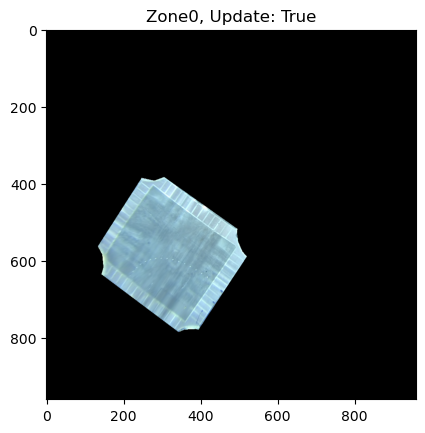

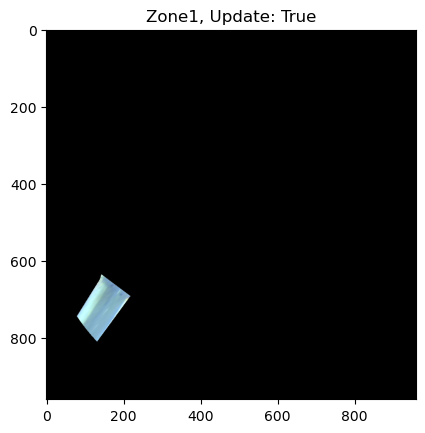

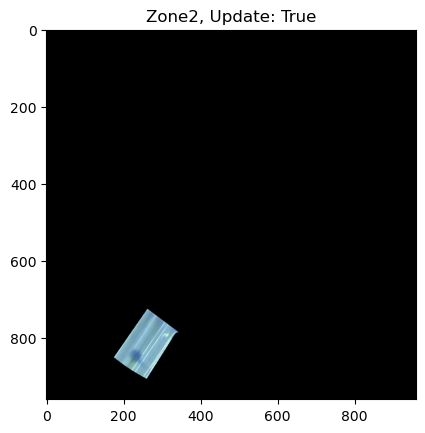

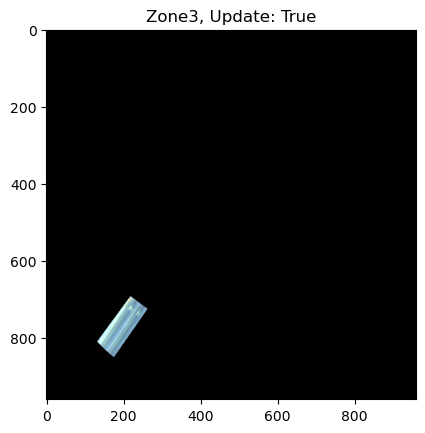

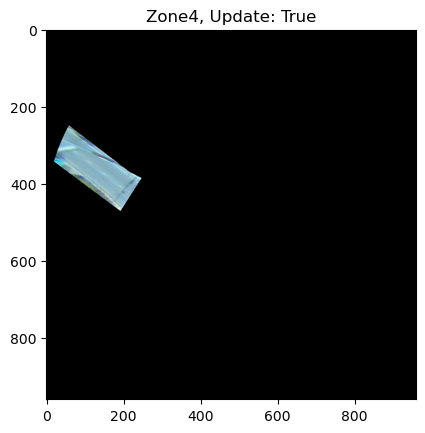

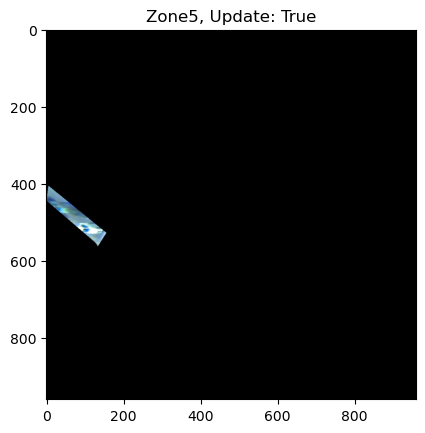

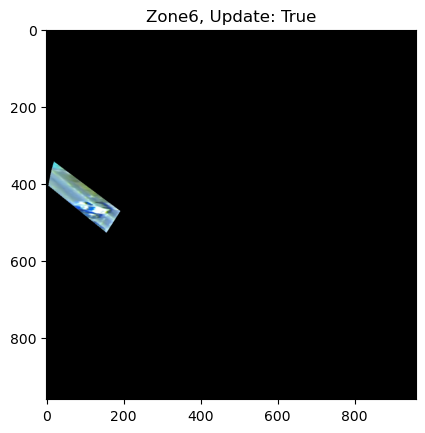

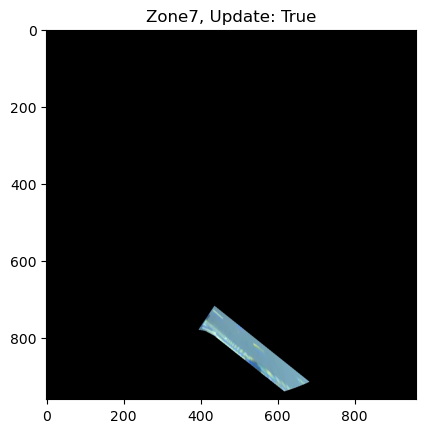

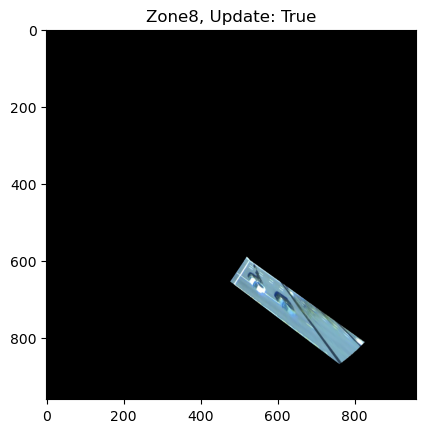

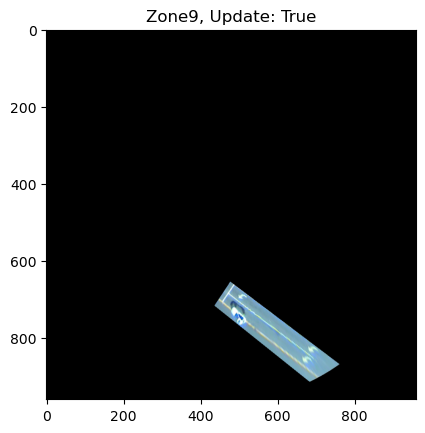

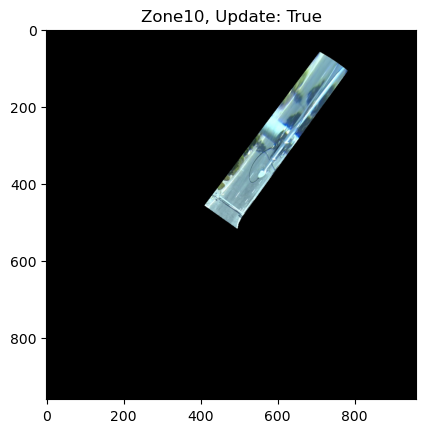

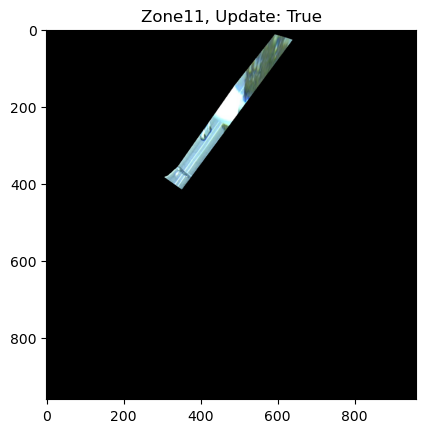

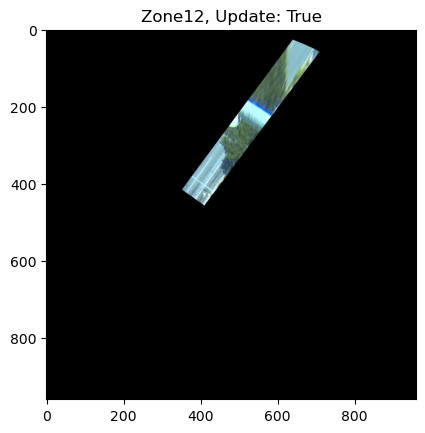

In [25]:
idx_frame = 0
img = cv2.imread(os.path.join(path,files[idx_frame])) # read the first image

start_time = time.time()

of_trigger = BgOpticalFlowTrigger(img, mask_flow, mask_tuple)
zone_init_list = [ZoneInitializer(old_bg_img, mask_tuple, i) for i in range(13)]

frame_num = 400

while 1:
    idx_frame += 1
    if idx_frame >= frame_num: break

    img = cv2.imread(os.path.join(path,files[idx_frame]))

    of_trigger.update(img)
    
    for i in range(13):
        zone_init_list[i].bg_update(img, of_trigger.is_zone_triggered(i))

    print('################ Frame:', idx_frame, '################',files[idx_frame])

print('Time/frame', (time.time() - start_time) / frame_num)

for i in range(13):
    plt.imshow(cv2.cvtColor(zone_init_list[i].get_bg(), cv2.COLOR_BGR2RGB))
    plt.title('Zone' + str(i) + ', Update: ' + str(zone_init_list[i].update_flag))
    plt.show()

In [48]:
zone_init_list[0].get_bg().mean()

63.736044560185185

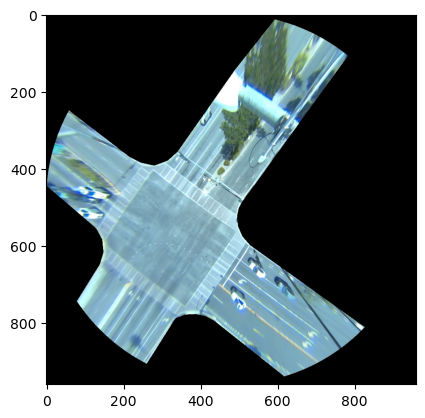

In [43]:
temp_img = zone_init_list[0].get_bg()
for i in range(1, 13):
    temp_img += zone_init_list[i].get_bg()

plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
plt.show()

In [44]:
old_bg_img.nbytes

2764800

In [46]:
960*960*3

2764800

## Test (Multiprocessing)

In [10]:
import multiprocessing

def mp_bg_update_wrapper(instance, *args):
    start_time = time.time()
    
    instance.bg_update(*args)
    print('process time', time.time() - start_time)

if __name__ == '__main__':
    idx_frame = 0
    img = cv2.imread(os.path.join(path,files[idx_frame])) # read the first image

    start_time = time.time()

    of_trigger = BgOpticalFlowTrigger(img, mask_flow, mask_tuple)
    zone_init_list = [ZoneInitializer(old_bg_img, mask_tuple, i) for i in range(13)]

    frame_num = 5

    while 1:
        idx_frame += 1
        if idx_frame >= frame_num: break

        img = cv2.imread(os.path.join(path,files[idx_frame]))

        of_trigger.update(img)

        pool = multiprocessing.Pool(13)
        for i in range(13):
            pool.apply_async(func = mp_bg_update_wrapper, 
                             args = (zone_init_list[i], img, of_trigger.is_zone_triggered(i)))
        pool.close()
        pool.join()

        print('################ Frame:', idx_frame, '################',files[idx_frame])

    print('Time/frame', (time.time() - start_time) / frame_num)

    for i in range(13):
        plt.imshow(cv2.cvtColor(zone_init_list[i].get_bg(), cv2.COLOR_BGR2RGB))
        plt.show()

################ Frame: 1 ################ 2.jpg
################ Frame: 2 ################ 3.jpg
################ Frame: 3 ################ 4.jpg
################ Frame: 4 ################ 5.jpg
Time/frame 0.6388756275177002


error: OpenCV(4.5.2) /tmp/pip-req-build-sl2aelck/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Test

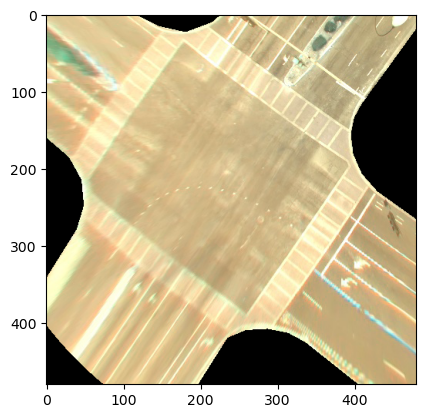

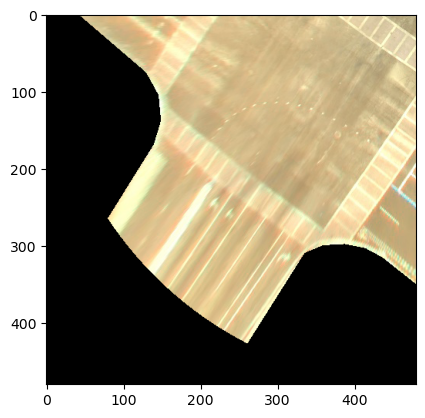

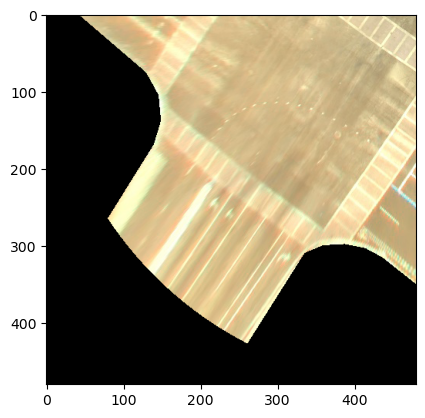

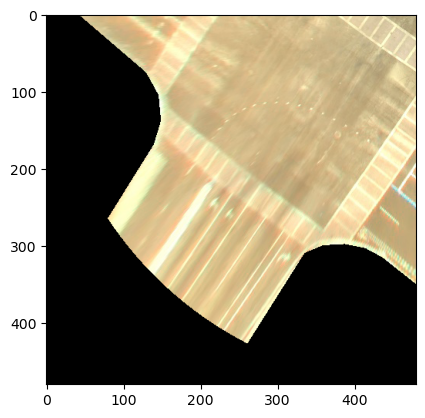

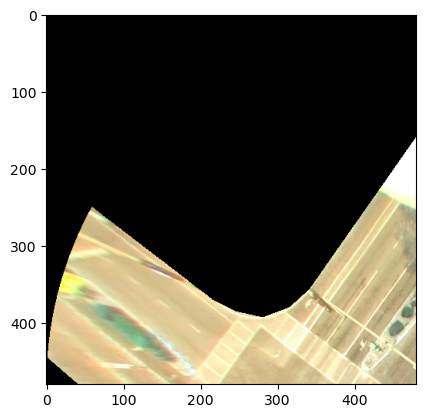

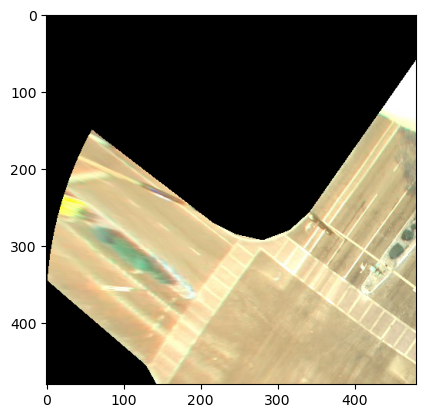

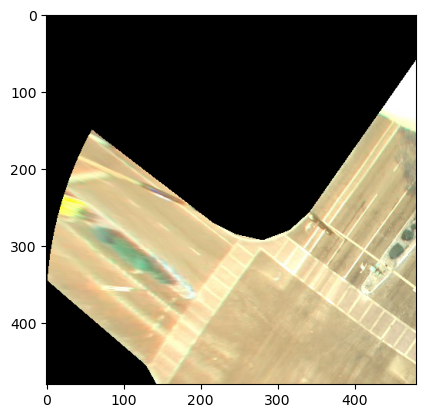

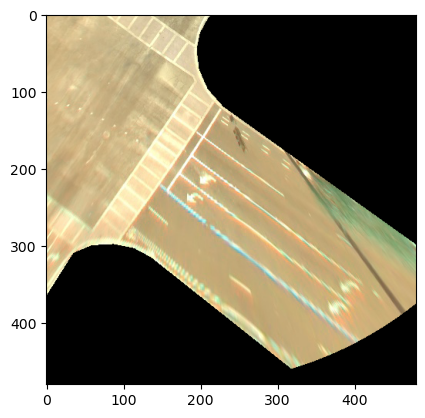

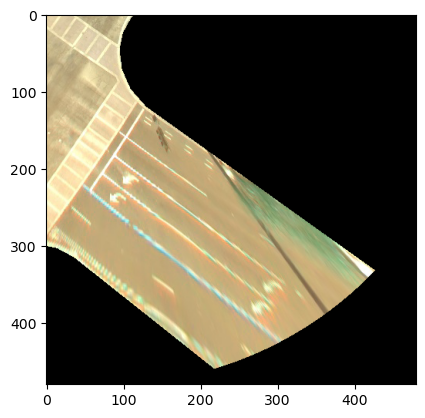

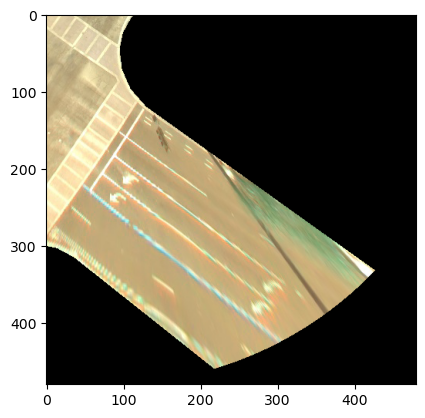

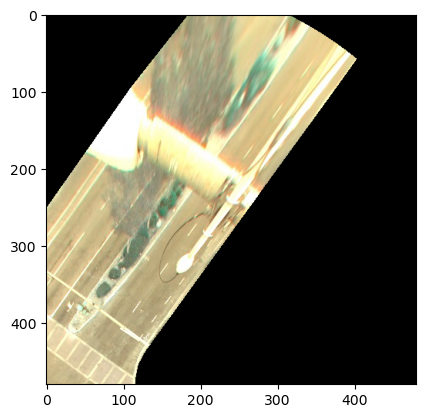

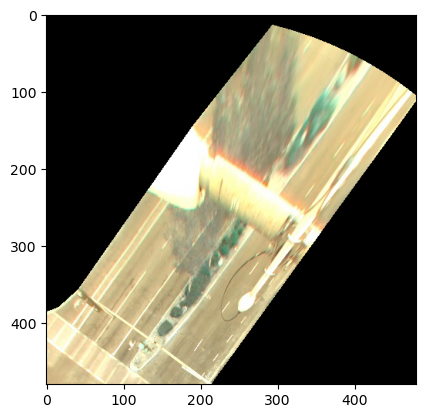

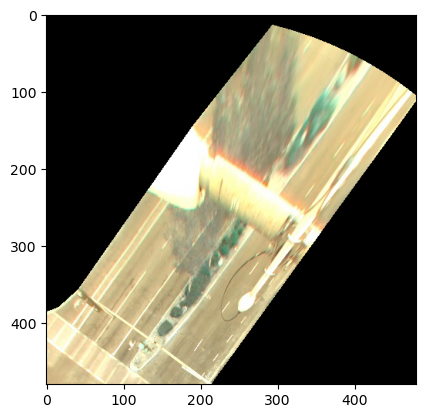

In [37]:
# Crop Old BG
for i in range(13):
    plt.imshow(old_bg_img[crop_position[i][0]: crop_position[i][0] + 480,
                        crop_position[i][1]: crop_position[i][1] + 480])
    plt.show()

In [10]:
a = [True, False, True]
b = np.ndarray(a)

TypeError: an integer is required

In [5]:
print(b)

[ True False  True]


In [7]:
b.dtype

dtype('bool')

In [8]:
b.nbytes

3

In [9]:
b.shape

(3,)